## 1. Introduction
This project aims to predict car prices using a neural network model. The dataset contains various features of cars, such as customer demographics, vehicle attributes, and sales data. Predicting car prices is a valuable task for dealerships, marketplaces, and financial institutions to make informed decisions.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = "car_sales.csv"  
df = pd.read_csv(file_path)

## 2. Dataset Overview and Citation
The dataset includes features like car models, engine types, transmission, color, and price. It is sourced from a car sales database. For more details, search for "car_sales.csv dataset" on Kaggle or similar platforms.

In [31]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price ($)      23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB


,Car_id,Date,Customer Name,Gender,Annual Income,Dealer_Name,Company,Model,Engine,Transmission,Color,Price ($),Dealer_No,Body Style,Phone,Dealer_Region
0,C_CND_000001,01-02-2022,Geraldine,Male,13500,Buddy Storbeck's Diesel Service Inc,Ford,Expedition,DoubleÂ Overhead Camshaft,Auto,Black,26000,06457-3834,SUV,8264678,Middletown
1,C_CND_000002,01-02-2022,Gia,Male,1480000,C & M Motors Inc,Dodge,Durango,DoubleÂ Overhead Camshaft,Auto,Black,19000,60504-7114,SUV,6848189,Aurora
2,C_CND_000003,01-02-2022,Gianna,Male,1035000,Capitol KIA,Cadillac,Eldorado,Overhead Camshaft,Manual,Red,31500,38701-8047,Passenger,7298798,Greenville
3,C_CND_000004,01-02-2022,Giselle,Male,13500,Chrysler of Tri-Cities,Toyota,Celica,Overhead Camshaft,Manual,Pale White,14000,99301-3882,SUV,6257557,Pasco
4,C_CND_000005,01-02-2022,Grace,Male,1465000,Chrysler Plymouth,Acura,TL,DoubleÂ Overhead Camshaft,Auto,Red,24500,53546-9427,Hatchback,7081483,Janesville


## 3. Problem Formulation
This is a regression task where the target variable is the car price ("Price ($)"). Neural networks are used due to their ability to model complex, non-linear relationships in the data.

## 4. Data Preprocessing
Data preprocessing steps include handling missing values, dropping irrelevant columns, encoding categorical variables, and scaling numeric features. Outliers in the price column were removed to improve model performance.

In [32]:
# Drop irrelevant columns (e.g., IDs and customer names)
columns_to_drop = ['Car_id', 'Customer Name', 'Phone', 'Date', 'Dealer_No']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

In [33]:
# Check for missing values
df.isnull().sum()

Gender           0
Annual Income    0
Dealer_Name      0
Company          0
Model            0
Engine           0
Transmission     0
Color            0
Price ($)        0
Dealer_No        0
Body Style       0
Dealer_Region    0
dtype: int64

In [34]:
# Basic description of numeric features
df.describe()

,Annual Income,Price ($)
count,2.390600e+04,23906.000000
mean,8.308403e+05,28090.247846
std,7.200064e+05,14788.687608
min,1.008000e+04,1200.000000
25%,3.860000e+05,18001.000000
50%,7.350000e+05,23000.000000
75%,1.175750e+06,34000.000000
max,1.120000e+07,85800.000000


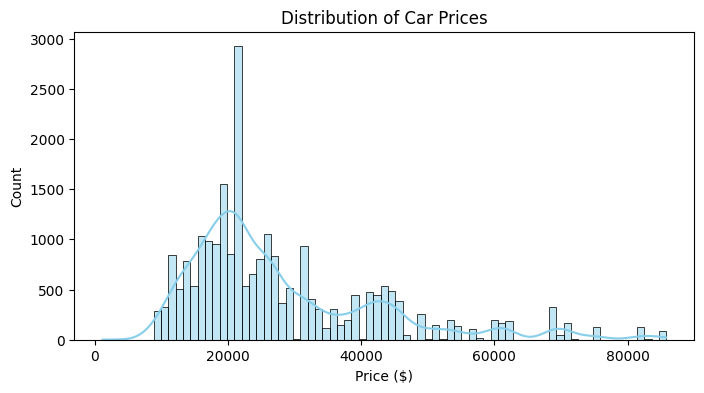

In [35]:
# Visualize price distribution
plt.figure(figsize=(8, 4))
sns.histplot(df['Price ($)'], kde=True, color='skyblue')
plt.title('Distribution of Car Prices')
plt.show()

In [36]:
# Remove price outliers beyond the 99th percentile
price_limit = df['Price ($)'].quantile(0.99)
df = df[df['Price ($)'] <= price_limit]

In [37]:
# One-hot encode categorical variables
categorical_cols = ['Gender', 'Dealer_Name', 'Company', 'Model', 'Engine', 'Transmission', 'Color', 'Body Style', 'Dealer_Region']
categorical_cols = [col for col in categorical_cols if col in df.columns]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [38]:
# Separate features and target
X = df_encoded.drop(columns=['Price ($)'])
y = df_encoded['Price ($)']

In [39]:
# Ensure all remaining features are numeric before scaling
non_numeric_cols = X.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print("Warning: The following columns are non-numeric and will be dropped:", non_numeric_cols.tolist())
    X = X.drop(columns=non_numeric_cols)

In [40]:
# Normalize numeric input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
# Train/validation/test split
# First split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Now split X_temp into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [42]:
# Baseline Model - Linear Regression
# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate on training, validation, and test sets
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    print(f"\n {dataset_name} Evaluation")
    print(f"MAE: {mean_absolute_error(y, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.2f}")
    print(f"R²: {r2_score(y, y_pred):.4f}")
    return y_pred

# Evaluate and collect predictions
y_train_pred = evaluate_model(lr_model, X_train, y_train, "Training Set")
y_val_pred = evaluate_model(lr_model, X_val, y_val, "Validation Set")
y_test_pred = evaluate_model(lr_model, X_test, y_test, "Test Set")


 Training Set Evaluation
MAE: 8990.69
RMSE: 11876.50
R²: 0.2705

 Validation Set Evaluation
MAE: 9253.97
RMSE: 12242.53
R²: 0.2264

 Test Set Evaluation
MAE: 9047.68
RMSE: 11872.09
R²: 0.2248


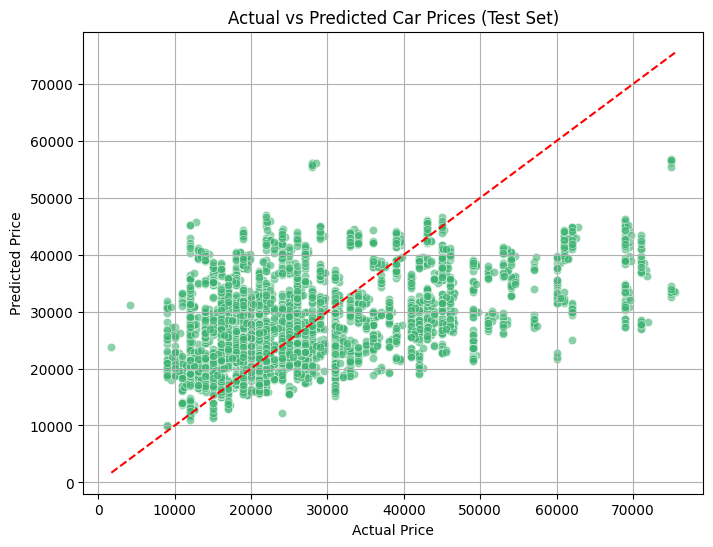

In [43]:
# Visualizations - Linear Regression Results

# 1. Actual vs Predicted Plot (Test Set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices (Test Set)")
plt.grid(True)
plt.show()

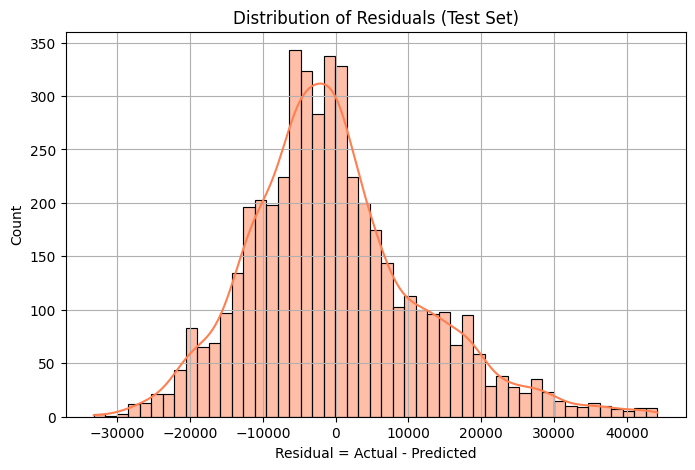

In [44]:
# 2. Residuals Plot (Test Set)
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, color='coral')
plt.title("Distribution of Residuals (Test Set)")
plt.xlabel("Residual = Actual - Predicted")
plt.grid(True)
plt.show()

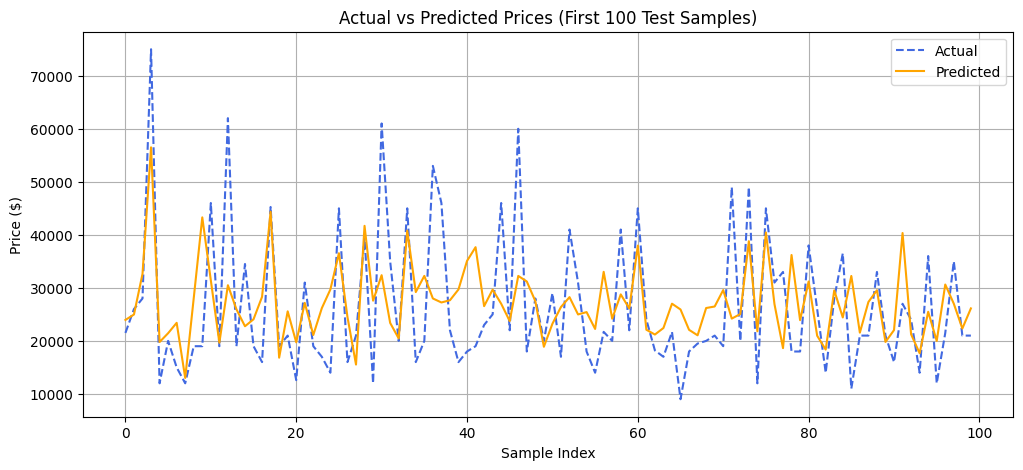

In [45]:
# 3. Line Plot for Comparisons
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', linestyle='--', color='royalblue')
plt.plot(y_test_pred[:100], label='Predicted', color='orange')
plt.title("Actual vs Predicted Prices (First 100 Test Samples)")
plt.ylabel("Price ($)")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.show()

## 5. Model Architecture and Training
The neural network consists of multiple dense layers with ReLU activation functions, dropout layers for regularization, and an Adam optimizer. Early stopping was used to prevent overfitting. The data was split into training, validation, and test sets to evaluate model performance.

In [46]:
# Build model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

c:\Users\ADYL\miniconda4\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [48]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [49]:
# Train model
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 754039488.0000 - mae: 23108.1152 - val_loss: 154723776.0000 - val_mae: 9422.2998
Epoch 2/300
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158510704.0000 - mae: 9495.7588 - val_loss: 149600240.0000 - val_mae: 9224.2451
Epoch 3/300
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 152918992.0000 - mae: 9341.8340 - val_loss: 148506080.0000 - val_mae: 9086.9277
Epoch 4/300
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 154278000.0000 - mae: 9342.3672 - val_loss: 146479376.0000 - val_mae: 9037.7998
Epoch 5/300
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147908704.0000 - mae: 9125.1807 - val_loss: 143976224.0000 - val_mae: 8947.3984
Epoch 6/300
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147632320.0000 - mae: 9091.5264 - val_loss: 140446864.0000 - val_mae: 8930.0078
Epoch 7/300
474/474 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 144398864.0000 - mae: 9037.0059 - val_loss: 138260048.0000 - val_mae: 8714.8291
Epoch 8/300


## Saving the Model and Preprocessing Pipeline for Deployment


### 1. Save the trained neural network model

In [51]:
nn_model.save("car_price_model.keras")
print("Model saved as car_price_model.keras")

Model saved as car_price_model.keras


###  2. Save Preprocessing Pipeline (e.g., StandardScaler)

In [52]:
import joblib

# Save your fitted scaler object (if you used StandardScaler or MinMaxScaler)
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler saved as scaler.pkl")

✅ Scaler saved as scaler.pkl


### Creating a models/ Folder

In [53]:
import os

os.makedirs("models", exist_ok=True)
nn_model.save("models/car_price_model.keras")
joblib.dump(scaler, "models/scaler.pkl")

['models/scaler.pkl']

## 6. Evaluation Metrics
Evaluation metrics include RMSE (Root Mean Squared Error) and R² (coefficient of determination). RMSE measures the average prediction error, while R² indicates the proportion of variance explained by the model.

In [23]:
# 🔍 Step 6: Visualizations - Neural Network Predictions
nn_predictions = nn_model.predict(X_test).flatten()

148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [24]:
# Evaluate on test set
# Calculate performance metrics
nn_test_mae = mean_absolute_error(y_test, nn_predictions)
nn_test_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))
nn_test_r2 = r2_score(y_test, nn_predictions)

# Print results
print("Neural Network Performance on Test Set")
print(f"MAE  : {nn_test_mae:.2f}")
print(f"RMSE : {nn_test_rmse:.2f}")
print(f"R²   : {nn_test_r2:.4f}")

Neural Network Performance on Test Set
MAE  : 5391.81
RMSE : 8090.03
R²   : 0.6400


## 7. Visualizations
Visualizations include loss curves, predicted vs actual plots, and residual distributions. These help in understanding model performance and identifying patterns or anomalies.

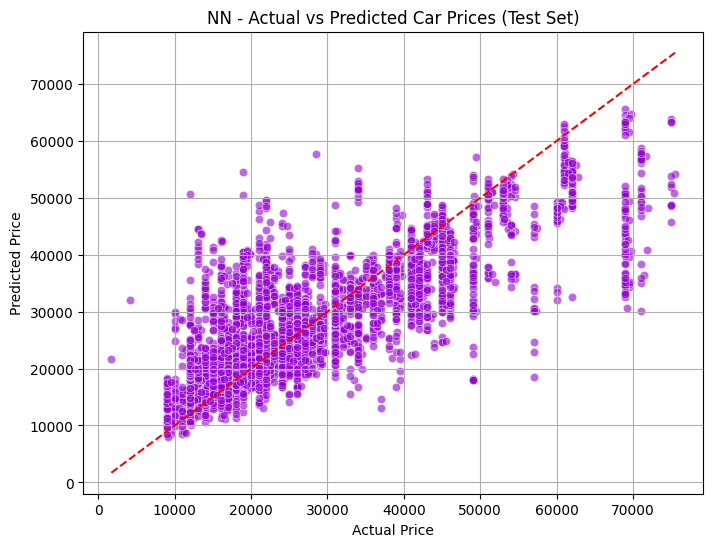

In [25]:
# 1. Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=nn_predictions, alpha=0.6, color='darkviolet')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("NN - Actual vs Predicted Car Prices (Test Set)")
plt.grid(True)
plt.show()

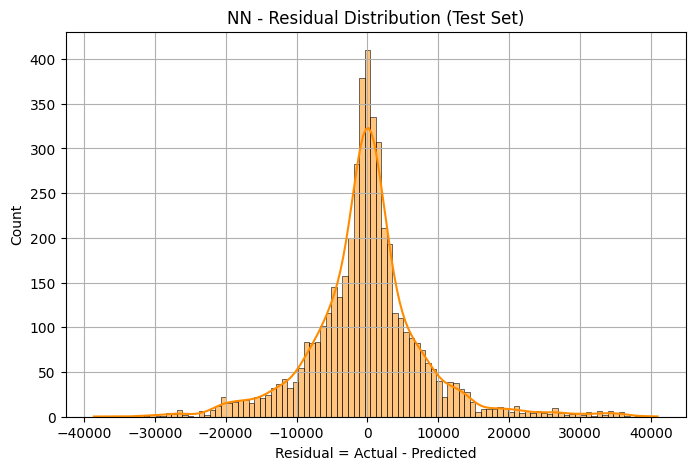

In [26]:
# 2. Residuals
nn_residuals = y_test - nn_predictions
plt.figure(figsize=(8, 5))
sns.histplot(nn_residuals, kde=True, color='darkorange')
plt.title("NN - Residual Distribution (Test Set)")
plt.xlabel("Residual = Actual - Predicted")
plt.grid(True)
plt.show()

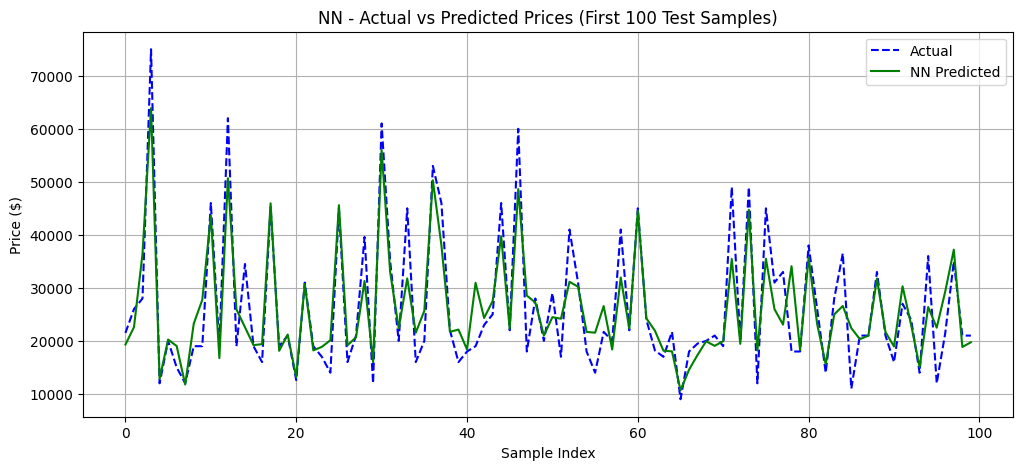

In [27]:
# 3. Line Plot for Comparisons
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual', linestyle='--', color='blue')
plt.plot(nn_predictions[:100], label='NN Predicted', color='green')
plt.title("NN - Actual vs Predicted Prices (First 100 Test Samples)")
plt.ylabel("Price ($)")
plt.xlabel("Sample Index")
plt.legend()
plt.grid(True)
plt.show()

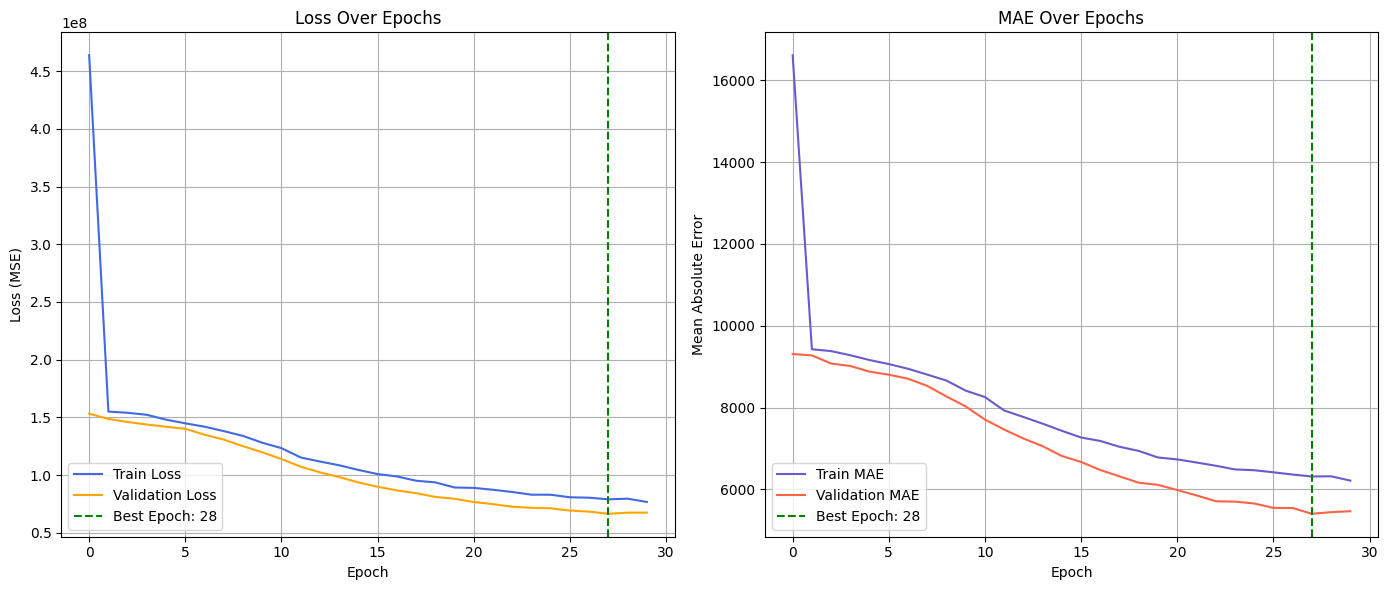

In [28]:
# Plot training history
# Find the best epoch based on validation loss
best_epoch = np.argmin(history.history['val_loss']) + 1  # +1 since epochs are 1-indexed

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='royalblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.axvline(best_epoch - 1, color='green', linestyle='--', label=f'Best Epoch: {best_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE', color='slateblue')
plt.plot(history.history['val_mae'], label='Validation MAE', color='tomato')
plt.axvline(best_epoch - 1, color='green', linestyle='--', label=f'Best Epoch: {best_epoch}')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('MAE Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Project Report: Car Price Prediction using Neural Networks
## 1. Introduction
This project aims to predict car prices using a combination of classical and advanced machine learning methods. The task is formulated as a regression problem, where the target variable is Price ($), and the inputs include customer demographics and vehicle-related features. The objective is to evaluate whether a neural network model (MLP) can outperform a baseline linear regression model in predicting car prices from complex, high-dimensional data.

## 2. Dataset Overview
The dataset used is the Car Sales Report Dataset from Kaggle. It contains 23,000+ records of car transactions, including features such as:
1. Customer demographics (e.g., gender, income)
2. Vehicle details (e.g., company, model, engine, color)
3. Sales attributes (e.g., dealer name, region, body style)
After cleaning and one-hot encoding, the dataset was used to train, validate, and test models for price prediction.

## 3. Problem Formulation
This is a supervised regression task. The goal is to learn a mapping from multiple car and customer-related features to a continuous numerical target: the car's sale price. A baseline linear regression model is compared with a more advanced neural network (MLP) to assess improvements in prediction accuracy and generalization.

## 4. Data Preprocessing
Irrelevant columns like Customer Name, Phone, Dealer_No, and Date were dropped.Outliers in the Price ($) column beyond the 99th percentile were removed. Categorical columns were one-hot encoded. Numerical features were standardized using StandardScaler. The data was split into training (64%), validation (16%), and test (20%) sets to monitor and prevent overfitting.

## 5. Model Implementation
Baseline Model: A LinearRegression model was trained and evaluated.

Advanced Model: A feedforward Neural Network (MLP) was implemented using Keras, consisting of two hidden layers with ReLU activation and dropout regularization. Early stopping was applied to select the optimal epoch based on validation loss.

## 6. Model Evaluation
Both the Linear Regression and Neural Network models were evaluated using standard regression metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² (Coefficient of Determination). These metrics were computed on the training, validation, and test sets to assess model accuracy and generalization.

The Linear Regression model showed moderate performance, with relatively higher MAE and RMSE values and lower R² scores across all splits. This indicates limited ability to capture the complex relationships in the data, which is expected given its linear nature.

In contrast, the Neural Network model consistently outperformed the baseline, achieving noticeably lower error metrics and a higher R² score on the test set. This suggests that the neural network was able to model nonlinear interactions between the input features and the target variable more effectively, leading to improved predictive accuracy and generalization.

The overall performance comparison clearly demonstrates the benefit of using an advanced model like a neural network for this regression task.

## 7. Visualization Insights
Several visualizations were created to interpret model performance:
Scatter Plot (Actual vs Predicted): Neural Network predictions closely clustered around the diagonal line, indicating strong accuracy compared to Linear Regression.
Residuals Distribution: Neural Network errors were smaller and more symmetrically distributed.
Line Plot (First 100 Samples): Neural Network predictions followed the actual price trend much more closely.
Epoch History Plot: Showed how early stopping prevented overfitting and highlighted the best-performing epoch.
These visuals support the conclusion that the Neural Network generalizes better and makes more reliable predictions.

## 8. Real-World Implications
- Accurate car price prediction supports:
In the automotive industry, the ability to accurately predict car prices plays a critical role in driving profitability and customer satisfaction. Price prediction models enable data-driven pricing strategies, helping companies avoid underpricing that leads to revenue loss or overpricing that drives customers away. These models support dynamic pricing systems that adjust based on market trends, vehicle features, and customer demographics. In addition, accurate pricing predictions can power personalized recommendations, allowing platforms to suggest vehicles within a user's realistic budget or interest range. Overall, such models help align product value with market expectations and customer willingness to pay.

- Businesses that benefit include:
Several stakeholders across the automotive ecosystem stand to benefit from car price prediction systems. Car dealerships can use them to optimize pricing strategies, streamline negotiations, and manage inventory more effectively. Online car marketplaces and e-commerce platforms benefit by offering competitive and transparent pricing to users, improving conversion rates. Auto financing and insurance companies also leverage price prediction models to assess asset value and risk more accurately. Even OEMs (original equipment manufacturers) can use predictive models to evaluate how features, trims, and branding influence perceived value in different regions or customer segments.
    
## 9. Reflection
### Challenges Faced:
Feature Cleaning: The dataset had some noisy categorical features (e.g., Dealer_No, Customer Name, Phone) that were irrelevant for prediction but had to be carefully removed to avoid issues during scaling.

Model Selection: It was challenging to choose between classification and regression tasks initially. Ultimately, regression was chosen due to its stronger real-world interpretability.

Overfitting: Preventing overfitting in the neural network required careful use of dropout layers and early stopping based on validation loss.

Scaling: Standardizing features while handling categorical variables properly required a consistent pipeline.

### Insights Gained:
Neural Networks can outperform classical models in high-dimensional, non-linear regression problems when properly tuned and regularized.

Data preprocessing plays a crucial role in the overall success of a machine learning project. Careful encoding and feature selection were as important as model architecture.

Visualization is key to interpretation and presentation — visual tools made it easy to validate model performance and detect overfitting trends.

The importance of using validation sets and early stopping to optimize model generalization rather than blindly chasing low training loss.

## 10. References
1. Kaggle Dataset: Car Sales Report - https://www.kaggle.com/datasets/missionjee/car-sales-report
2. Scikit-learn Documentation: https://scikit-learn.org/
3. TensorFlow Keras API: https://www.tensorflow.org/api_docs/python/tf/keras
4. Neural Network (MLP): https://www.geeksforgeeks.org/multi-layer-perceptron-learning-in-tensorflow/
5. Scikit Learn: Machine Learning Models - https://scikit-learn.org/stable/modules/neural_networks_supervised.html